In [1]:
import numpy as np

X = np.array([[5, 8], [6, 7], [6, 5], [2, 4], [3, 4], [5, 4], [7, 4], [9, 4], [3, 3], [8, 2], [7, 5]])
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']

In [2]:
def contingency_table(x, y):
    n = x.shape[0]
    n00 = 0
    n11 = 0
    n01 = 0
    n10 = 0
    for i in range(n):
        if x[i] == 1 and y[i] == 1:
            n11 += 1
        elif x[i] == 1 and y[i] == 0:
            n10 += 1
        elif x[i] == 0 and y[i] == 1:
            n10 += 1
        else:
            n00 += 1
    return n00, n01, n10, n11

def SMC(x, y):
    n00, n01, n10, n11 = contingency_table(x, y)
    return (n00 + n11) / (n00 + n01 + n10 + n11 + 0.0)

def Jaccard(x, y):
    n00, n01, n10, n11 = contingency_table(x, y)
    return n11 / (n11 + n10 + n01 + 0.0)

def Rao(x, y):
    n00, n01, n10, n11 = contingency_table(x, y)
    return n11 / (n11 + n10 + n01 + n00)

def L1(x, y):
    return np.linalg.norm((x - y), ord=1)

In [6]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

class Cluster:
    def __init__(self, label, indices, debug_info):
        self.label = label
        self.indices = indices
        self.debug_info = debug_info
        
    def __str__(self):
        return f"CL: \n\tlabel: {self.label} indices: {self.indices}\n"
    
    def __repr__(self):
        return f"CL{self.label}: \n\t{self.debug_info}\n"
    
    def size(self):
        return self.indices.shape[0]
    
    def getLabel(self):
        return self.label
    
    def getIndices(self):
        return self.indices
    
    def getDebugInfo(self):
        return self.debug_info
    
    def getIndex(self, i):
        return self.indices[i]

    
# Not efficient solution : add distance matrix and update method TODO    
class AgglomerativeClustering:
    def __init__(self):
        self.clusters = []
        self.history = []
    
    def fit(self, D, labels, pointDist, clusterDist):
        self.init(D, labels)
        k = 0
        while k < D.shape[0] - 1:
            d, i, j = self.inter_clusters_dist(D, pointDist, clusterDist)
            ci = self.clusters[i]
            cj = self.clusters[j]
            self.mergeClusters(i, j, D, labels)
            print(f" >>>> iter {k} dist: {d}")
            print(self.clusters)
            self.linkage_matrix[k] = np.array([ci.getLabel(), cj.getLabel(), d, ci.size() + cj.size()])
            k += 1
            
    def inter_clusters_dist(self, D, pointDist, clusterDist):
        min_dist = 10000.0 # TODO fix
        c_i = -1
        c_j = -1
        for i in range(len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                d = self.inter_cluster_dist(D, self.clusters[i], self.clusters[j], pointDist, clusterDist)
                if d < min_dist:
                    min_dist = d
                    c_i = i
                    c_j = j
        return min_dist, c_i, c_j
    
    def inter_cluster_dist(self, D, c1, c2, pointDist, clusterDist):
        if clusterDist == 'single_link':
            return self.min_cluster_dist(D, c1, c2, pointDist)
        elif clusterDist == 'complete_link':
            return self.max_cluster_dist(D, c1, c2, pointDist)
        elif clusterDist == 'group_average':
            return self.group_avg_dist(D, c1, c2, pointDist)
        return -1
    
    def min_cluster_dist(self, D, c1, c2, pointDist):
        n = c1.size()
        m = c2.size()
        min_dist = 10000.0 # TODO fix
        for i in range(n):
            for j in range(m):
                d = pointDist(D[c1.getIndex(i), :], D[c2.getIndex(j), :])
                if d < min_dist:
                    min_dist = d
        return min_dist
    
    def max_cluster_dist(self, D, c1, c2, pointDist):
        n = c1.size()
        m = c2.size()
        max_dist = 0.0 # TODO fix
        for i in range(n):
            for j in range(m):
                d = pointDist(D[c1.getIndex(i), :], D[c2.getIndex(j), :])
                if d > max_dist:
                    max_dist = d
        return max_dist
    
    def group_avg_dist(self, D, c1, c2, pointDist):
        n = c1.size()
        m = c2.size()
        sum_avg_dist = 0.0 # TODO fix
        for i in range(n):
            for j in range(m):
                d = pointDist(D[c1.getIndex(i), :], D[c2.getIndex(j), :])
                sum_avg_dist += d
        return sum_avg_dist / (n + m + 0.00001)
        
    def init(self, D, labels):
        # initially all points are clusters
        n = D.shape[0]
        for i in range(n):
            self.clusters.append(Cluster(i, np.array([i]), labels[i]))
        self.linkage_matrix = np.empty((n - 1, 4))
        self.counter = n
        print(" >>>> init")
        print(self.clusters)

            
    def mergeClusters(self, i, j, D, labels):
        label = self.counter
        self.counter += 1
        ci = self.clusters[i]
        cj = self.clusters[j]
        indices = np.concatenate([ci.getIndices(), cj.getIndices()])
        debug_info = ci.getDebugInfo() + ", " + cj.getDebugInfo()
        new_cluster = Cluster(label, indices, debug_info)
        self.clusters[i] = new_cluster
        self.clusters = self.clusters[:j] + self.clusters[j+1 :]
        
    def dendrogram_view(self, labels, clusterDist):
        row_dendr = dendrogram(self.linkage_matrix, labels=labels)
        plt.tight_layout()
        plt.ylabel(clusterDist)
        plt.show()

 >>>> init
[CL0: 
	a
, CL1: 
	b
, CL2: 
	c
, CL3: 
	d
, CL4: 
	e
, CL5: 
	f
, CL6: 
	g
, CL7: 
	h
, CL8: 
	i
, CL9: 
	j
, CL10: 
	k
]
 >>>> iter 0 dist: 1.0
[CL0: 
	a
, CL1: 
	b
, CL11: 
	c, k
, CL3: 
	d
, CL4: 
	e
, CL5: 
	f
, CL6: 
	g
, CL7: 
	h
, CL8: 
	i
, CL9: 
	j
]
 >>>> iter 1 dist: 1.0
[CL0: 
	a
, CL1: 
	b
, CL12: 
	c, k, g
, CL3: 
	d
, CL4: 
	e
, CL5: 
	f
, CL7: 
	h
, CL8: 
	i
, CL9: 
	j
]
 >>>> iter 2 dist: 1.0
[CL0: 
	a
, CL1: 
	b
, CL12: 
	c, k, g
, CL13: 
	d, e
, CL5: 
	f
, CL7: 
	h
, CL8: 
	i
, CL9: 
	j
]
 >>>> iter 3 dist: 1.0
[CL0: 
	a
, CL1: 
	b
, CL12: 
	c, k, g
, CL14: 
	d, e, i
, CL5: 
	f
, CL7: 
	h
, CL9: 
	j
]
 >>>> iter 4 dist: 2.0
[CL15: 
	a, b
, CL12: 
	c, k, g
, CL14: 
	d, e, i
, CL5: 
	f
, CL7: 
	h
, CL9: 
	j
]
 >>>> iter 5 dist: 2.0
[CL16: 
	a, b, c, k, g
, CL14: 
	d, e, i
, CL5: 
	f
, CL7: 
	h
, CL9: 
	j
]
 >>>> iter 6 dist: 2.0
[CL17: 
	a, b, c, k, g, f
, CL14: 
	d, e, i
, CL7: 
	h
, CL9: 
	j
]
 >>>> iter 7 dist: 2.0
[CL18: 
	a, b, c, k, g, f, d, e, i
, CL

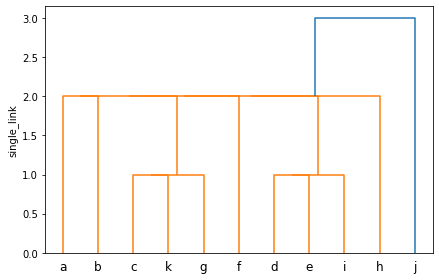

In [7]:
a = AgglomerativeClustering()
a.fit(X, labels, L1, 'single_link')
a.dendrogram_view(labels, 'single_link')

 >>>> init
[CL0: 
	ID_0
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL3: 
	ID_3
, CL4: 
	ID_4
, CL5: 
	ID_5
]
 >>>> iter 0 dist: 0.0
[CL0: 
	ID_0
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL6: 
	ID_3, ID_4
, CL5: 
	ID_5
]
 >>>> iter 1 dist: 0.2
[CL7: 
	ID_0, ID_3, ID_4
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL5: 
	ID_5
]
 >>>> iter 2 dist: 0.2
[CL8: 
	ID_0, ID_3, ID_4, ID_1
, CL2: 
	ID_2
, CL5: 
	ID_5
]
 >>>> iter 3 dist: 0.2
[CL9: 
	ID_0, ID_3, ID_4, ID_1, ID_2
, CL5: 
	ID_5
]
 >>>> iter 4 dist: 0.2
[CL10: 
	ID_0, ID_3, ID_4, ID_1, ID_2, ID_5
]


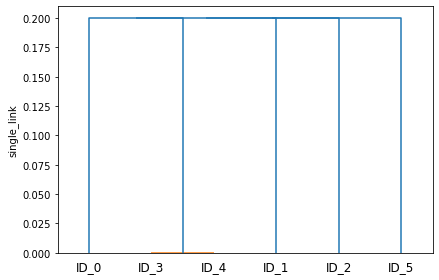

In [8]:
X = np.array([[1, 0, 1, 1, 0], [1, 1, 0, 1, 0], [0, 0, 1, 1, 0], [0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 1, 0, 0]])
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5']

a = AgglomerativeClustering()
a.fit(X, labels, Rao, 'single_link')
a.dendrogram_view(labels, 'single_link')

 >>>> init
[CL0: 
	ID_0
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL3: 
	ID_3
, CL4: 
	ID_4
, CL5: 
	ID_5
]
 >>>> iter 0 dist: 0.0
[CL0: 
	ID_0
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL6: 
	ID_3, ID_4
, CL5: 
	ID_5
]
 >>>> iter 1 dist: 0.4
[CL7: 
	ID_0, ID_5
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL6: 
	ID_3, ID_4
]
 >>>> iter 2 dist: 0.4
[CL7: 
	ID_0, ID_5
, CL8: 
	ID_1, ID_2
, CL6: 
	ID_3, ID_4
]
 >>>> iter 3 dist: 0.6
[CL9: 
	ID_0, ID_5, ID_3, ID_4
, CL8: 
	ID_1, ID_2
]
 >>>> iter 4 dist: 0.8
[CL10: 
	ID_0, ID_5, ID_3, ID_4, ID_1, ID_2
]


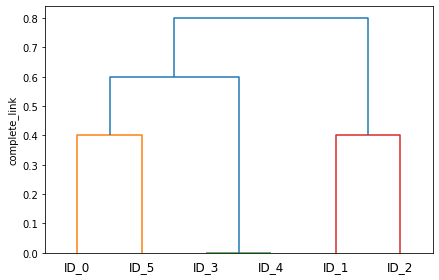

In [9]:
a = AgglomerativeClustering()
a.fit(X, labels, SMC, 'complete_link')
a.dendrogram_view(labels, 'complete_link')

 >>>> init
[CL0: 
	ID_0
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL3: 
	ID_3
, CL4: 
	ID_4
, CL5: 
	ID_5
]
 >>>> iter 0 dist: 0.0
[CL0: 
	ID_0
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL6: 
	ID_3, ID_4
, CL5: 
	ID_5
]
 >>>> iter 1 dist: 0.12499937500312498
[CL7: 
	ID_0, ID_5
, CL1: 
	ID_1
, CL2: 
	ID_2
, CL6: 
	ID_3, ID_4
]
 >>>> iter 2 dist: 0.12499937500312498
[CL7: 
	ID_0, ID_5
, CL8: 
	ID_1, ID_2
, CL6: 
	ID_3, ID_4
]
 >>>> iter 3 dist: 0.33333250000208337
[CL9: 
	ID_0, ID_5, ID_3, ID_4
, CL8: 
	ID_1, ID_2
]
 >>>> iter 4 dist: 0.533332444445926
[CL10: 
	ID_0, ID_5, ID_3, ID_4, ID_1, ID_2
]


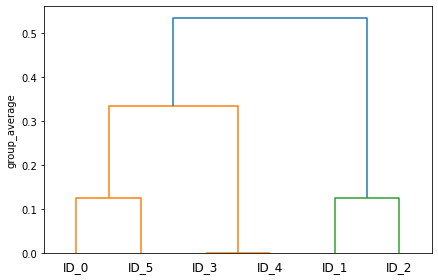

In [10]:
a = AgglomerativeClustering()
a.fit(X, labels, Jaccard, 'group_average')
a.dendrogram_view(labels, 'group_average')